# Explore classification stats

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from penquins import Kowalski
import yaml

In [2]:
# This cell will work if you have added kowalski tokens to your config.yaml

config_path = "../config.yaml"
with open(config_path) as config_yaml:
    config = yaml.load(config_yaml, Loader=yaml.FullLoader)

hosts = [
    x
    for x in config['kowalski']['hosts']
    if config['kowalski']['hosts'][x]['token'] is not None
]

instances = {
    host: {
        'protocol': config['kowalski']['protocol'],
        'port': config['kowalski']['port'],
        'host': f'{host}.caltech.edu',
        'token': config['kowalski']['hosts'][host]['token'],
    }
    for host in hosts
}

# try setting up K connection if token is available
if len(instances) > 0:
    kowalski_instances = Kowalski(
        timeout=config["kowalski"]["timeout"], instances=instances
    )

In [3]:
# Test connection
for host in hosts:
    print(host, kowalski_instances.ping(name=host))

kowalski True
gloria True
melman True


In [4]:
query = {
    "query_type": "aggregate",
    "query": {
        "catalog": config["kowalski"]["collections"]["classifications"],
        "pipeline": [
            {
                "$project": {
                    "_id": 0,
                    "vnv_xgb": 1,
                }
            },
            {
                "$bucket": {
                    "groupBy": "$vnv_xgb",
                    "boundaries": np.arange(0, 1.01, 0.01).tolist()
                }
            }
        ]
    },
    "kwargs": {
        "max_time_ms": 300 * 1e3
    }
}
response = kowalski_instances.query(query=query, name='gloria')
print(response)

{'gloria': {'status': 'success', 'message': 'Successfully executed query', 'data': [{'_id': 0.0, 'count': 5121857}, {'_id': 0.01, 'count': 6572569}, {'_id': 0.02, 'count': 4490911}, {'_id': 0.03, 'count': 3271551}, {'_id': 0.04, 'count': 2513460}, {'_id': 0.05, 'count': 1990143}, {'_id': 0.06, 'count': 1615848}, {'_id': 0.07, 'count': 1335642}, {'_id': 0.08, 'count': 1128224}, {'_id': 0.09, 'count': 965341}, {'_id': 0.1, 'count': 840574}, {'_id': 0.11, 'count': 739111}, {'_id': 0.12, 'count': 658284}, {'_id': 0.13, 'count': 591437}, {'_id': 0.14, 'count': 533728}, {'_id': 0.15, 'count': 486028}, {'_id': 0.16, 'count': 444850}, {'_id': 0.17, 'count': 409685}, {'_id': 0.18, 'count': 380355}, {'_id': 0.19, 'count': 353132}, {'_id': 0.2, 'count': 330209}, {'_id': 0.21, 'count': 309188}, {'_id': 0.22, 'count': 292050}, {'_id': 0.23, 'count': 275628}, {'_id': 0.24, 'count': 261639}, {'_id': 0.25, 'count': 248917}, {'_id': 0.26, 'count': 238383}, {'_id': 0.27, 'count': 228232}, {'_id': 0.28, 

In [5]:
data = response.get("gloria").get("data")
score_lower_bounds = [entry["_id"] for entry in data]
counts = [entry["count"] for entry in data]
counts

[5121857,
 6572569,
 4490911,
 3271551,
 2513460,
 1990143,
 1615848,
 1335642,
 1128224,
 965341,
 840574,
 739111,
 658284,
 591437,
 533728,
 486028,
 444850,
 409685,
 380355,
 353132,
 330209,
 309188,
 292050,
 275628,
 261639,
 248917,
 238383,
 228232,
 218337,
 210018,
 201871,
 194375,
 187962,
 182310,
 176827,
 171524,
 166663,
 162388,
 158446,
 153300,
 149984,
 146347,
 143121,
 139476,
 136334,
 133745,
 131387,
 128400,
 125555,
 122706,
 119742,
 117622,
 114792,
 113001,
 111364,
 108930,
 108131,
 106746,
 105639,
 104582,
 103320,
 103017,
 102457,
 101848,
 102099,
 102351,
 101869,
 102101,
 101640,
 101863,
 102592,
 102004,
 102315,
 102433,
 101865,
 101451,
 101501,
 100295,
 100369,
 100269,
 100859,
 100060,
 100029,
 99630,
 99119,
 98889,
 98421,
 96300,
 95543,
 92626,
 90224,
 87633,
 84593,
 81385,
 77469,
 74680,
 70752,
 64539,
 55945,
 53371]

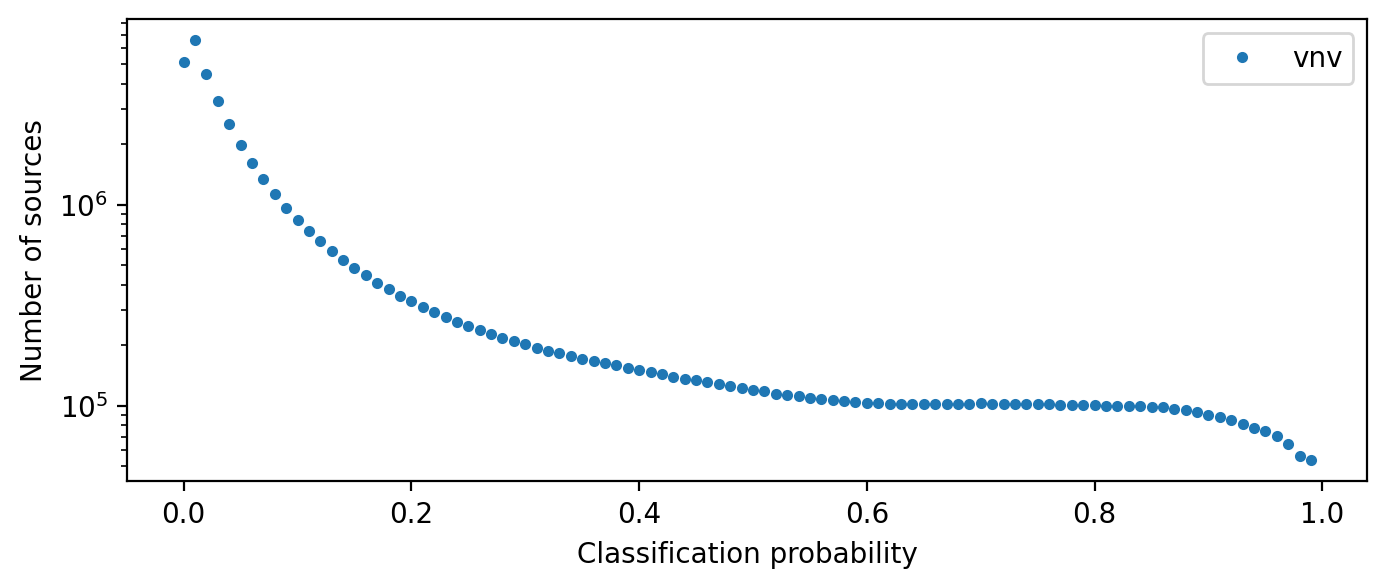

In [6]:
# Plot number of sources per probability bin for 'variable' label (from XGB classifier)

fig = plt.figure(figsize=(8, 3), dpi=200)
ax = fig.add_subplot(1, 1, 1)
ax.plot(
    score_lower_bounds,
    counts,
    ".",
    label='vnv'
)
ax.set_yscale("log")
ax.set_xlabel('Classification probability')
ax.set_ylabel('Number of sources')
ax.legend()
